/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

amazon_polarity/train-00000-of-00004.par(…):   0%|          | 0.00/260M [00:00<?, ?B/s]

amazon_polarity/train-00001-of-00004.par(…):   0%|          | 0.00/258M [00:00<?, ?B/s]

amazon_polarity/train-00002-of-00004.par(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

amazon_polarity/train-00003-of-00004.par(…):   0%|          | 0.00/254M [00:00<?, ?B/s]

amazon_polarity/test-00000-of-00001.parq(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Dataset loaded. Train size: 3600000

PROCESSING REVIEW #0
RAW INPUT TO INTAKE AGENT:
[REVIEW #0 | Label=Positive]
This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
User email: john.doe0@example.com
Phone: +1 555-1200-4567
Please note: possible refund and credit card issues.


=== Message from IntakeAgent to PlannerAgent ===
RAW:
[REVIEW #0 | Label=Positive]
This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresh

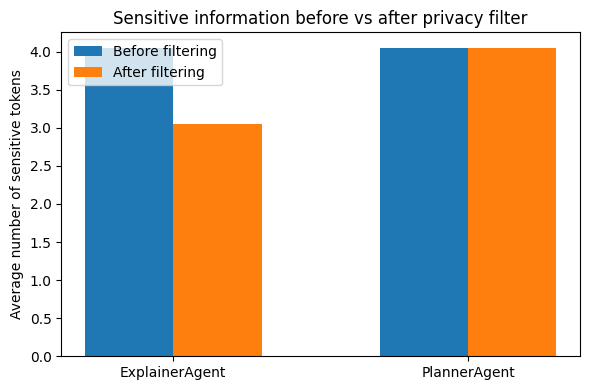

In [1]:
!pip install datasets --quiet

import re
from datasets import load_dataset
from typing import List, Dict, Callable

import pandas as pd
import matplotlib.pyplot as plt

USE_REAL_LLM = False  # keep False unless you have API quota + API key set up

def dummy_policy(role_description: str, message: str) -> str:
    """
    Local 'fake LLM' – no API usage.
    """
    return (
        f"[{role_description}]: I received the message. "
        f"Here is a brief safe summary:\n"
        f"{message[:200]}"
    )


def model_policy(role_description: str, message: str) -> str:
    """
    Switch between dummy model and real OpenAI LLM if USE_REAL_LLM=True.
    """
    if USE_REAL_LLM:
        from openai import OpenAI
        client = OpenAI()
        system_prompt = (
            f"You are a {role_description} in a privacy-aware multi-agent system.\n"
            f"- Do NOT infer or guess masked data.\n"
            f"- Only use visible information."
        )
        try:
            resp = client.chat.completions.create(
                model="gpt-4.1-mini",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": message},
                ],
                max_tokens=150,
                temperature=0.2,
            )
            return resp.choices[0].message.content.strip()
        except Exception as e:
            return f"[API ERROR: {e}]"
    else:
        return dummy_policy(role_description, message)

class PrivacyFilter:
    EMAIL = re.compile(r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+")
    PHONE = re.compile(r"\b(\+?\d{1,3}[-.\s]?)?(\d{3}[-.\s]?\d{3}[-.\s]?\d{4})\b")

    def __init__(self, sensitive_keywords=None):
        if sensitive_keywords is None:
            sensitive_keywords = [
                "refund", "visa", "credit card", "address", "phone",
                "SECRET_KEY", "PATIENT_ID"
            ]
        self.sensitive_keywords = sensitive_keywords

    def redact_pii(self, text: str) -> str:
        text = self.EMAIL.sub("[REDACTED_EMAIL]", text)
        text = self.PHONE.sub("[REDACTED_PHONE]", text)
        return text

    def mask_sensitive_keywords(self, text: str) -> str:
        for key in self.sensitive_keywords:
            pattern = re.compile(re.escape(key), flags=re.IGNORECASE)
            text = pattern.sub(f"[MASK_{key.upper()}]", text)
        return text

    def apply(self, text: str) -> str:
        return self.mask_sensitive_keywords(self.redact_pii(text))


def count_sensitive_tokens(text: str, pf: PrivacyFilter) -> Dict[str, int]:
    """
    Count how many sensitive items appear in a given text:
    - emails
    - phones
    - sensitive keywords
    Returns a dict with counts and a total so we can visualize later.
    """
    email_count = len(pf.EMAIL.findall(text))
    phone_count = len(pf.PHONE.findall(text))
    keyword_count = 0
    for key in pf.sensitive_keywords:
        pattern = re.compile(re.escape(key), flags=re.IGNORECASE)
        keyword_count += len(pattern.findall(text))

    total = email_count + phone_count + keyword_count
    return {
        "emails": email_count,
        "phones": phone_count,
        "keywords": keyword_count,
        "total_sensitive": total,
    }


# 3. Agents & Multi-Agent System

class Agent:
    def __init__(self, name: str, role: str, can_see_sensitive=False):
        self.name = name
        self.role = role
        self.can_see_sensitive = can_see_sensitive
        self.memory: List[str] = []

    def receive(self, message: str) -> str:
        self.memory.append(message)
        response = model_policy(self.role, message)
        self.memory.append("RESPONSE: " + response)
        return response


class MultiAgentSystem:
    def __init__(self, privacy_filter: PrivacyFilter):
        self.agents: Dict[str, Agent] = {}
        self.graph: Dict[str, List[str]] = {}
        self.filter = privacy_filter
        self.logs: List[Dict[str, str]] = []  # to store raw/delivered messages

    def add_agent(self, agent: Agent):
        self.agents[agent.name] = agent
        self.graph.setdefault(agent.name, [])

    def add_edge(self, src: str, dst: str):
        self.graph[src].append(dst)

    def send(self, src: str, dst: str, message: str):
        target = self.agents[dst]
        raw = message
        delivered = raw if target.can_see_sensitive else self.filter.apply(raw)

        # store in logs for later analysis
        self.logs.append({
            "src": src,
            "dst": dst,
            "raw": raw,
            "delivered": delivered,
        })

        print(f"\n=== Message from {src} to {dst} ===")
        print("RAW:")
        print(raw)
        print("\nDELIVERED:")
        print(delivered)

        response = target.receive(delivered)

        print("\nRESPONSE:")
        print(response)

    def broadcast(self, src: str, message: str):
        for dst in self.graph[src]:
            self.send(src, dst, message)

dataset = load_dataset("amazon_polarity")
print("Dataset loaded. Train size:", len(dataset["train"]))

pf = PrivacyFilter()
mas = MultiAgentSystem(pf)

intake = Agent("IntakeAgent", "review ingestion agent", can_see_sensitive=True)
planner = Agent("PlannerAgent", "quality control reviewer", can_see_sensitive=True)
explainer = Agent("ExplainerAgent", "customer-facing explainer", can_see_sensitive=False)

mas.add_agent(intake)
mas.add_agent(planner)
mas.add_agent(explainer)

mas.add_edge("IntakeAgent", "PlannerAgent")
mas.add_edge("IntakeAgent", "ExplainerAgent")

for i in range(20):
    sample = dataset["train"][i]
    review_text = sample["content"]
    label = "Positive" if sample["label"] == 1 else "Negative"

    raw_input = (
        f"[REVIEW #{i} | Label={label}]\n"
        f"{review_text}\n"
        f"User email: john.doe{i}@example.com\n"
        f"Phone: +1 555-12{i:02d}-4567\n"
        f"Please note: possible refund and credit card issues.\n"
    )

    print("\n" + "=" * 80)
    print(f"PROCESSING REVIEW #{i}")
    print("=" * 80)
    print("RAW INPUT TO INTAKE AGENT:")
    print(raw_input)

    mas.broadcast("IntakeAgent", raw_input)

rows = []
for idx, log in enumerate(mas.logs):
    before = count_sensitive_tokens(log["raw"], pf)
    after = count_sensitive_tokens(log["delivered"], pf)

    rows.append({
        "message_id": idx,
        "src": log["src"],
        "dst": log["dst"],
        "before_emails": before["emails"],
        "before_phones": before["phones"],
        "before_keywords": before["keywords"],
        "before_total": before["total_sensitive"],
        "after_emails": after["emails"],
        "after_phones": after["phones"],
        "after_keywords": after["keywords"],
        "after_total": after["total_sensitive"],
    })

df = pd.DataFrame(rows)
print("\n=== RESULTS TABLE (first 10 rows) ===")
print(df.head(10))

grouped = df.groupby("dst")[["before_total", "after_total"]].mean().reset_index()
print("\n=== AVERAGE SENSITIVE TOKENS BY RECEIVER ===")
print(grouped)

# Simple bar plot: before vs after for Planner vs Explainer
plt.figure(figsize=(6, 4))

x = range(len(grouped))
plt.bar([i - 0.15 for i in x], grouped["before_total"], width=0.3, label="Before filtering")
plt.bar([i + 0.15 for i in x], grouped["after_total"], width=0.3, label="After filtering")

plt.xticks(x, grouped["dst"])
plt.ylabel("Average number of sensitive tokens")
plt.title("Sensitive information before vs after privacy filter")
plt.legend()
plt.tight_layout()
plt.show()
